# Using vireo for multiplexing, followed by lineage tracing of those groups

# 1. Set up

In [1]:
import os
from scipy.sparse import csc_matrix

os.chdir("/data2/mito_lineage/")#Analysis/multiplex")

In [2]:
# papermill --cwd /data2/mito_lineage -p INDIR {INDIR} -p OUTDIR data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/clones -p  src/vireo/2_MT_Lineage_Construct.ipynb 

In [3]:
pwd

'/data2/mito_lineage'

### Remove this when running in snakemake

## 1.1 Parameters

In [4]:
# INDIR=""
# OUTDIR=""
# N_DONORS=5

# INDIR= "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex"
# OUTDIR= "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/clones/"
# N_DONORS=2
DEBUG=True

INDIR= "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex"
OUTDIR = "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/clones"
N_DONORS=2
exp="post"

In [5]:
# # Parameters
# #INDIR="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/"
# INDIR=""
# OUTDIR=""
# #OUTDIR="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/lineages"
# N_DONORS=5

## 1.2 Import packages

In [6]:
from os.path import join, exists, dirname
from icecream import ic
from glob import glob
import mplh.cluster_help as ch
import os
from vireoSNP.plot.base_plot import heat_matrix
from vireoSNP import Vireo
import src.pseudo_batch as pb
import vireoSNP
ic(vireoSNP.__version__)
from tqdm import tqdm
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.vireo.vireo_utils import run_vireo, plot_vireo_out, extract_clusters, run_elbo, separate_donors
%load_ext autoreload
%autoreload 2
from src.vireo.vireo_utils import run_lineage
#np.set_icoptions(formatter={'float': lambda x: format(x, '.5f')})

ic| vireoSNP.__version__: '0.5.6'


In [7]:
from src.utils.data_io import load_mtx_df

In [8]:
if not DEBUG:
    ic.disable()


# 2 Lineage construction for each donor. Filter by exp

In [9]:
# num_cores = 12# N_DONORS #multiprocessing.cpu_count()
# inputs = tqdm(np.arange(N_DONORS))
# for n in np.arange(N_DONORS):
#     ic('n', n)
#     run_lineage(n, INDIR, OUTDIR, n_clone_list=[5, 10, 20, 40, 100], rerun_model=False)

In [10]:
n_clone_list=[20, 40, 100]

In [11]:
cells_meta = pd.read_csv(join(INDIR, f"cells_meta.tsv"), sep='\t')

cells_meta=cells_meta.astype({"donor_index": "Int64", "donor": "Int64"})
cells_meta = cells_meta[cells_meta["condition"]==exp]
cells_meta

,new index,ID,raw ID,condition,donor,donor_index
5538,5539,AAACGAAAGAACAGGA-1_post,AAACGAAAGAACAGGA-1,post,1,2721
5539,5540,AAACGAAAGATTGACA-1_post,AAACGAAAGATTGACA-1,post,1,2722
5540,5541,AAACGAAAGCGTTGCC-1_post,AAACGAAAGCGTTGCC-1,post,0,2614
5541,5542,AAACGAAAGGTACTCT-1_post,AAACGAAAGGTACTCT-1,post,1,2723
5542,5543,AAACGAAAGGTTAACA-1_post,AAACGAAAGGTTAACA-1,post,0,2615
...,...,...,...,...,...,...
15584,15585,TTTGTGTTCCGGAAAG-1_post,TTTGTGTTCCGGAAAG-1,post,1,8015
15585,15586,TTTGTGTTCCTGACCT-1_post,TTTGTGTTCCTGACCT-1,post,1,8016
15586,15587,TTTGTGTTCGGATGTT-1_post,TTTGTGTTCGGATGTT-1,post,0,6745
15587,15588,TTTGTGTTCTTAATCC-1_post,TTTGTGTTCTTAATCC-1,post,1,8017


/data/isshamie/software/anaconda3/envs/mito_trace/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='donor', ylabel='count'>

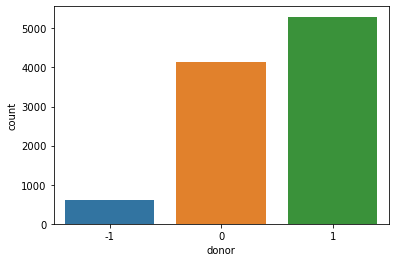

In [12]:
sns.countplot(cells_meta["donor"].fillna(-1))

ic| curr_ad_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor0.AD.mtx'
ic| curr_dp_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor0.DP.mtx'


clone: [20] donor: 0


ic| curr_ad.shape: (90723, 3)
ic| 'Before filtering'
ic| cells_meta.shape: (4133, 6)
ic| 'After filtering'
ic| cells_meta.shape: (4133, 7)
ic| allAD.shape: (1425, 4133)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic|

lineage 0: 15 cells 
(364, 3)
(364, 3)
donor0_lineage0
lineage 1: 74 cells 
(1759, 3)
(1759, 3)
donor0_lineage1


 len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)


lineage 2: 11 cells 
(288, 3)
(288, 3)
donor0_lineage2
lineage 3: 10 cells 
(211, 3)
(211, 3)
donor0_lineage3


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)


lineage 4: 121 cells 
(2793, 3)
(2793, 3)
donor0_lineage4
lineage 5: 10 cells 
(246, 3)
(246, 3)
donor0_lineage5


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0


lineage 6: 32 cells 
(743, 3)
(743, 3)
donor0_lineage6
lineage 7: 7 cells 
(169, 3)
(169, 3)
donor0_lineage7


ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique(

lineage 8: 19 cells 
(467, 3)
(467, 3)
donor0_lineage8
lineage 9: 13 cells 
(276, 3)
(276, 3)
donor0_lineage9


))-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0


lineage 10: 11 cells 
(250, 3)
(250, 3)
donor0_lineage10
lineage 11: 7 cells 
(176, 3)
(176, 3)
donor0_lineage11


ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)


lineage 12: 6 cells 
(159, 3)
(159, 3)
donor0_lineage12
lineage 13: 20 cells 
(473, 3)
(473, 3)
donor0_lineage13


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)


lineage 14: 19 cells 
(483, 3)
(483, 3)
donor0_lineage14
lineage 15: 4 cells 
(101, 3)
(101, 3)
donor0_lineage15


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)


lineage 16: 24 cells 
(560, 3)
(560, 3)
donor0_lineage16
lineage 17: 131 cells 
(3005, 3)
(3005, 3)
donor0_lineage17


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4133, 9)


lineage 18: 6 cells 
(159, 3)
(159, 3)
donor0_lineage18
lineage 19: 217 cells 
(4818, 3)
(4818, 3)
donor0_lineage19


ic| lin_cells_meta.head():    index  new index                       ID              raw ID condition  \
                           0      0       5541  AAACGAAAGCGTTGCC-1_post  AAACGAAAGCGTTGCC-1      post   
                           1      1       5543  AAACGAAAGGTTAACA-1_post  AAACGAAAGGTTAACA-1      post   
                           2      2       5547  AAACGAAAGTGCTAGG-1_post  AAACGAAAGTGCTAGG-1      post   
                           3      3       5553  AAACGAACATAGAATG-1_post  AAACGAACATAGAATG-1      post   
                           4      4       5554  AAACGAACATCCCAAA-1_post  AAACGAACATCCCAAA-1      post   
                           
                              donor  donor_index  lineage  lineage_index  
                           0      0         2614      NaN            NaN  
                           1      0         2615      NaN            NaN  
                           2      0         2616      NaN            NaN  
                           3      0       

     condition  lineage
3416      post       -1
159       post       17
502       post       -1
1499      post       -1
3950      post       -1
clustering
cmap Oranges
AF_SNPs shape (1425, 20)
clustering
cmap Blues


ic| curr_ad_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor1.AD.mtx'
ic| curr_dp_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor1.DP.mtx'


clone: [20] donor: 1


ic| curr_ad.shape: (140489, 3)
ic| 'Before filtering'
ic| cells_meta.shape: (5297, 6)
ic| 'After filtering'
ic| cells_meta.shape: (5297, 7)
ic| allAD.shape: (1428, 5297)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0


lineage 0: 16 cells 
(471, 3)
(471, 3)
donor1_lineage0
lineage 1: 32 cells 
(899, 3)
(899, 3)
donor1_lineage1


ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)


lineage 2: 2 cells 
(71, 3)
(71, 3)
donor1_lineage2
lineage 3: 204 cells 
(5542, 3)
(5542, 3)
donor1_lineage3


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)


lineage 4: 12 cells 
(303, 3)
(303, 3)
donor1_lineage4
lineage 5: 213 cells 
(5950, 3)
(5950, 3)
donor1_lineage5


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds)

lineage 6: 13 cells 
(393, 3)
(393, 3)
donor1_lineage6
lineage 7: 6 cells 
(173, 3)
(173, 3)
donor1_lineage7


: 0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)
ic|

lineage 8: 224 cells 
(6088, 3)
(6088, 3)
donor1_lineage8
lineage 9: 47 cells 
(1402, 3)
(1402, 3)
donor1_lineage9


 len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 

lineage 10: 4 cells 
(128, 3)
(128, 3)
donor1_lineage10
lineage 11: 7 cells 
(208, 3)
(208, 3)
donor1_lineage11


0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)


lineage 12: 24 cells 
(719, 3)
(719, 3)
donor1_lineage12
lineage 13: 9 cells 
(256, 3)
(256, 3)
donor1_lineage13


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)


lineage 14: 7 cells 
(198, 3)
(198, 3)
donor1_lineage14
lineage 15: 60 cells 
(1663, 3)
(1663, 3)
donor1_lineage15


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)


lineage 16: 220 cells 
(5848, 3)
(5848, 3)
donor1_lineage16
lineage 17: 13 cells 
(345, 3)
(345, 3)
donor1_lineage17


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (5297, 9)


lineage 18: 1 cells 
(25, 3)
(25, 3)
donor1_lineage18
lineage 19: 13 cells 
(385, 3)
(385, 3)
donor1_lineage19


ic| lin_cells_meta.head():    index  new index                       ID              raw ID condition  \
                           0      0       5539  AAACGAAAGAACAGGA-1_post  AAACGAAAGAACAGGA-1      post   
                           1      1       5540  AAACGAAAGATTGACA-1_post  AAACGAAAGATTGACA-1      post   
                           2      2       5542  AAACGAAAGGTACTCT-1_post  AAACGAAAGGTACTCT-1      post   
                           3      3       5544  AAACGAAAGTAGAAGG-1_post  AAACGAAAGTAGAAGG-1      post   
                           4      4       5545  AAACGAAAGTAGTGTA-1_post  AAACGAAAGTAGTGTA-1      post   
                           
                              donor  donor_index  lineage  lineage_index  
                           0      1         2721      NaN            NaN  
                           1      1         2722      NaN            NaN  
                           2      1         2723      NaN            NaN  
                           3      1       

     condition  lineage
573       post       -1
2173      post       -1
1185      post       -1
1143      post       -1
4353      post       -1
clustering
cmap Oranges
AF_SNPs shape (1428, 20)
clustering
cmap Blues


ic| all_cells_meta.head():    index  new index                       ID              raw ID condition  \
                           0      0       5541  AAACGAAAGCGTTGCC-1_post  AAACGAAAGCGTTGCC-1      post   
                           1      1       5543  AAACGAAAGGTTAACA-1_post  AAACGAAAGGTTAACA-1      post   
                           2      2       5547  AAACGAAAGTGCTAGG-1_post  AAACGAAAGTGCTAGG-1      post   
                           3      3       5553  AAACGAACATAGAATG-1_post  AAACGAACATAGAATG-1      post   
                           4      4       5554  AAACGAACATCCCAAA-1_post  AAACGAACATCCCAAA-1      post   
                           
                              donor  donor_index  lineage  lineage_index  
                           0      0         2614     <NA>           <NA>  
                           1      0         2615     <NA>           <NA>  
                           2      0         2616     <NA>           <NA>  
                           3      0       

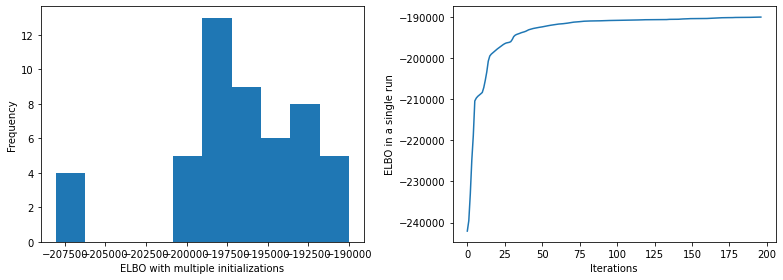

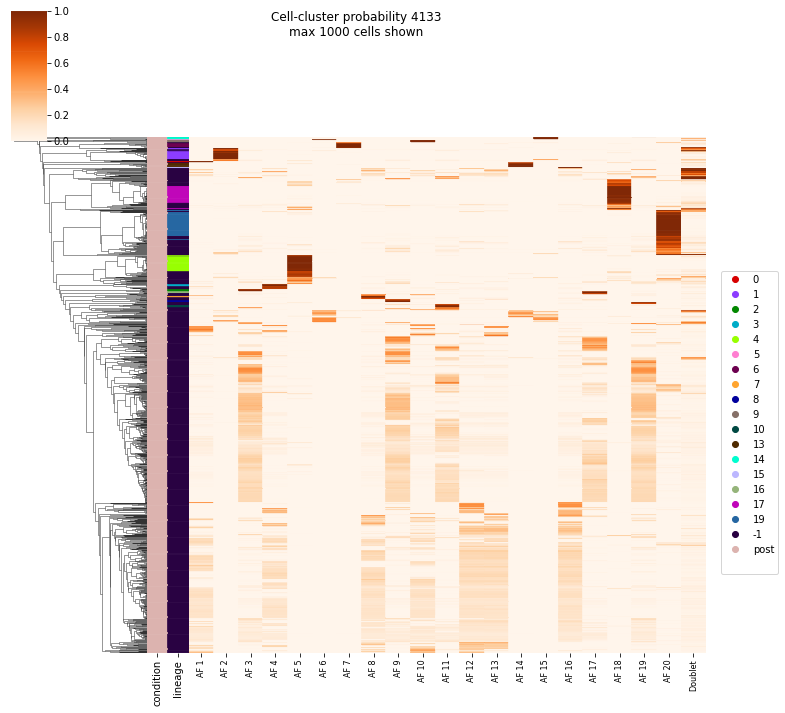

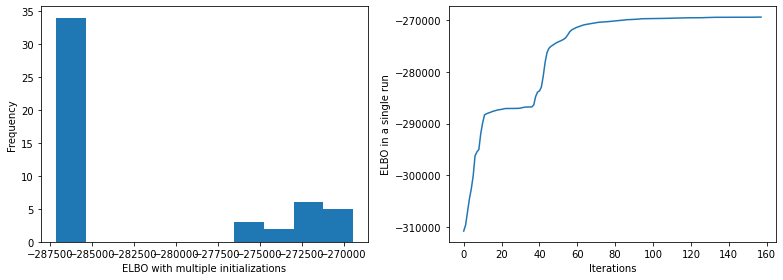

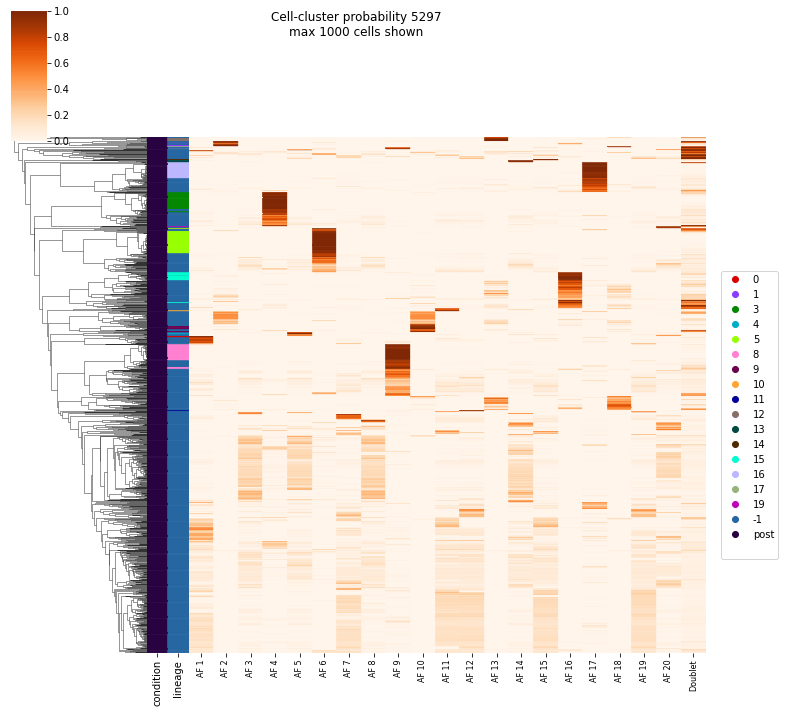

In [13]:
indir, outdir, n_donors, n_clone_list, cells_meta = INDIR, OUTDIR, N_DONORS, n_clone_list, cells_meta
n_clone_list = [20]
for clone in n_clone_list:
    cells_meta_col = f"lineage{clone}"
    curr_outdir = join(outdir, cells_meta_col)
    if not exists(curr_outdir):
        os.mkdir(curr_outdir)

    all_cells_meta = [] #concat across donors

    for donor in np.arange(n_donors):
        print(f'clone: {n_clone_list} donor: {donor}')
        curr_cells_meta = cells_meta.copy()
        curr_cells_meta = curr_cells_meta[curr_cells_meta["donor"] == donor].sort_values('donor_index').reset_index(drop=True)
        
        curr_ad_f = join(indir, f"donor{donor}.AD.mtx")
        curr_dp_f = join(indir, f"donor{donor}.DP.mtx")
        #curr_labels_f = join(indir, f"donor{donor}.labels.txt")
        curr_vcf_f = join(indir, f"donor{donor}.vcf")
        #curr_labels_rawID = join(indir, f"cell_labels.donor{donor}.txt")
        prefix=f"donor{donor}_"

        ic(curr_ad_f)
        ic(curr_dp_f)
        if not ((cells_meta["donor"] == donor).any()):
            print(f"Donor {donor} is empty. Continuing")
            continue
        #curr_ad = mmread(curr_ad_f).tocsc()
        #curr_dp = mmread(curr_dp_f).tocsc()
        curr_ad = load_mtx_df(curr_ad_f, skip_first=True, give_header=False,
            columns=("Variant", "Cell", "integer"), sep="\t").astype(int)
        curr_dp = load_mtx_df(curr_dp_f, skip_first=True, give_header=False, 
                              columns=("Variant", "Cell", "integer"), sep="\t").astype(int)
        
        cells_map = {x:ind+1 for ind, x in enumerate(curr_cells_meta["donor_index"].values)}

        curr_vcf = pd.read_csv(curr_vcf_f, sep='\t')
        # Get vcf inds to keep
        vcf_inds = (curr_ad["Variant"].astype(int).unique())
        ic(curr_vcf)
        curr_vcf = (curr_vcf.loc[vcf_inds-1]).reset_index() # 0 based index
        
        curr_ad["Cell"] = curr_ad["Cell"].map(cells_map)#curr_cells_meta.set_index("donor_index")['ID'])
        curr_dp["Cell"] = curr_dp["Cell"].map(cells_map)#curr_cells_meta.set_index("donor_index")['ID'])
        curr_ad = curr_ad.dropna(subset=("Cell",)).astype(int)
        curr_dp = curr_dp.dropna(subset=("Cell",)).astype(int)
        ic(curr_ad.shape)
        #curr_labels = pd.read_csv(curr_labels_f, index_col=0)
        
        assert(len(curr_ad["Cell"].unique())==len(curr_cells_meta["ID"].unique()))


        #curr_cells_meta = pd.read_csv(curr_labels_rawID, index_col=0)
#             ic('curr_labels')
#             ic(curr_labels.head())
        prefix = f"donor{donor}_"
        model_name = f"{prefix}lineage_{clone}"
        
        curr_ad = csc_matrix((curr_ad["integer"], 
                              (curr_ad["Variant"]-1, curr_ad["Cell"]-1)))
        curr_dp = csc_matrix((curr_dp["integer"], 
                              (curr_dp["Variant"]-1, curr_dp["Cell"]-1)))

        modelCA, elbo = run_vireo(curr_ad, curr_dp, clone, n_cores=32, plot_qc=True,out_f=join(curr_outdir, model_name))
        try:
            doublet_prob = modelCA.predict_doublet(curr_ad, curr_dp, update_GT=False, update_ID=False)[0].sum(axis=1)
        except AttributeError: # New version of Vireo 2021
            #doublet_prob = vireoSNP.utils.vireo_doublet.predict_doublet(modelCA,AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)
            doublet_prob = vireoSNP.utils.vireo_doublet.predict_doublet(modelCA, curr_ad, curr_dp, update_GT=False, update_ID=False)[0].sum(axis=1)

        separate_donors(curr_ad, curr_dp, modelCA, curr_cells_meta, curr_outdir,
                        doublet_prob,
                        prob_thresh=0.9, doublet_thresh=0.9,
                        cells_ind_col='donor_index',
                        out_name="lineage", prefix=prefix, cells_filt_col="donor", 
                        cells_filt_val=donor, vars_meta=curr_vcf)    

        lin_cells_meta = pd.read_csv(join(curr_outdir, f"{prefix}cells_meta.tsv"), sep='\t')
        ic(lin_cells_meta.head())
        ic(lin_cells_meta.shape)
        all_cells_meta.append(lin_cells_meta)
        ic("Plotting AF SNPs")
        lin_cells_meta = lin_cells_meta.astype({"lineage": 'Int64'}) #.fillna(-1).astype(str)
        lin_cells_meta['Assigned'] = ~(lin_cells_meta["lineage"].isnull())
        plot_vireo_out(modelCA, out_f=join(curr_outdir, model_name+"OUT"), 
                       labels=lin_cells_meta[["condition", "lineage"]].fillna(-1), 
                       doublet_prob=doublet_prob)

        plt.close()

    # Concat cells_meta across donors
    all_cells_meta = pd.concat(all_cells_meta, axis=0)
    all_cells_meta = all_cells_meta.astype({"lineage_index": "Int64", "lineage": "Int64"})
    ic(all_cells_meta.head())
    ic(all_cells_meta.shape)
    all_cells_meta.to_csv(join(curr_outdir, "cells_meta.tsv"), sep='\t')
    

In [14]:
# plot_vireo_out(modelCA, out_f=join(curr_outdir, model_name+"OUT"), 
#                labels=lin_cells_meta.reset_index()[["condition", "Assigned"]].fillna(-1), 
#                doublet_prob=doublet_prob)


In [15]:
# def separate_donors(AD, DP, modelCA, cells_meta, outdir,
#                 doublet_prob,
#                 prob_thresh=0.9, doublet_thresh=0.9,
#                 cells_ind_col='new index',
#                 out_name="donor", prefix="",
#                 cells_filt_col=None, cells_filt_val=None, vars_meta=None):
# """Separates the matrices and labels by donor using the multiplex output.

# :param AD: sparse matrix, position-by-cell.
# :param DP: sparse matrix, position-by-cell.
# :param modelCA:
# :param cells_meta:
# :param outdir:
# :param N_DONORS:
# :param doublet_prob:
# :param prob_thresh:
# :param doublet_thresh:
# :return:
# """
# low_conf_cells = np.flatnonzero(doublet_prob > doublet_thresh)
# cell_clusters = dict()

# # filter for certain columns
# if cells_filt_col is not None and cells_filt_val is not None:
#     cells_meta = cells_meta[cells_meta[cells_filt_col]==cells_filt_val]
# cells_meta = cells_meta.reset_index()

# allAD = pd.DataFrame(AD.todense())
# allDP = pd.DataFrame(DP.todense())
# ic(allAD.shape)
# ic(allAD.head())

# #assert((min(cells_meta.index)==1))
# cells_meta[out_name] = np.nan
# cells_meta[f"{out_name}_index"] = np.nan # Add additional index
# # For each donor, extract their cells for their matrices and labels
# # print('cell meta')
# # print(cells_meta.head())
# for n in range(modelCA.ID_prob.shape[1]):
#     # Drop low probability and/or high doublet probability
#     cell_clusters[n] = np.sort(np.flatnonzero(
#         (modelCA.ID_prob[:, n] > prob_thresh)))
#     cell_clusters[n] = np.sort(cell_clusters[n][
#         ~(np.isin(cell_clusters[n], low_conf_cells))])

#     ## Extract specific AD+DP indices and re-index to 1-based
#     # 1. make dense 0-based and take only the cluster indices
#     curr_ad = allAD.loc[:, cell_clusters[n]].reset_index().melt(
#         id_vars='index', var_name="Cell",
#         value_name="Count").rename({"index": "Position"}, axis=1)

#     curr_dp = allDP.loc[:, cell_clusters[n]].reset_index().melt(
#         id_vars='index', var_name="Cell",
#         value_name="Count").rename({"index": "Position"}, axis=1)


#     # 2. Then drop indices with AD=0 to make sparse to remove positions/cells.
#     #    This may remove some cells
#     curr_dp = curr_dp.loc[~(curr_ad["Count"] == 0)]
#     curr_ad = curr_ad.loc[~(curr_ad["Count"] == 0)]

#     #i for ind, valcell_clusters[n]
#     # 3. Assign cells_meta labels and indices based on curr_dp 0-based indices.

#     # If any labels were removed from step 2, remove
#     keep_inds = np.sort(list(set(cell_clusters[n]).intersection((set(curr_ad["Cell"].values)))))
#     ic(len(curr_dp["Cell"].unique())-len(keep_inds))
#     ic(cells_meta.shape)
#     cells_meta.loc[keep_inds, out_name] = n # df is 1-based index but model is 0-based
#     cells_meta.loc[keep_inds, f"{out_name}_index"] = np.arange(1,len(keep_inds)+1) # Set new index to 1-based
#     cells_meta = cells_meta.astype({f"{out_name}_index": "Int64", out_name: "Int64"})


#     # 4. Update the cell and position maps using dp, making it 1-based
#     #curr_cell_map = {val-1: val for val in cells_meta[f"{out_name}_index"].values} #1-based to 0-based
#     curr_cell_map = {val: ind + 1 for ind, val in
#                      enumerate(np.sort(curr_dp["Cell"].unique()))}
#     curr_pos_map = {val: ind + 1 for ind, val in enumerate(
#         np.sort(curr_dp["Position"].unique()))}
#     curr_ad["Cell"] = curr_ad["Cell"].map(curr_cell_map)
#     curr_ad["Position"] = curr_ad["Position"].map(curr_pos_map)
#     curr_dp["Cell"] = curr_dp["Cell"].map(curr_cell_map)
#     curr_dp["Position"] = curr_dp["Position"].map(curr_pos_map)

#     ic(curr_cell_map)
#     # 5. Get only the passed variants
#     if vars_meta is not None:
#         curr_vars_meta = vars_meta.iloc[curr_pos_map.keys()]

#     print(f"{out_name} {n}: {len(cell_clusters[n])} cells ")
#     print(curr_dp.shape)
#     print(curr_ad.shape)

#     # Get cell labels for specific lineages
#     curr_cells_meta = cells_meta.loc[keep_inds].copy()
#     curr_cells_meta = curr_cells_meta.reset_index() #make it 0-based
#     # Get their IDs
#     if outdir != "" and exists(outdir):
#         curr_out = join(outdir, f"{prefix}{out_name}{n}_cells.txt")
#         curr_str = "\n".join(cell_clusters[n].astype(str))
#         with open(curr_out, "w") as f:
#             f.write(curr_str)
#         curr_cells_meta.to_csv(
#             join(outdir, f"{prefix}{out_name}{n}.labels.txt"))
#         curr_cells_meta.to_csv(
#             join(outdir, f"cell_labels.{prefix}{out_name}{n}.txt"))
#         #print('curr_ad', curr_ad.head())
#         wrap_write_mtx_df(outdir, curr_ad, curr_dp,
#                           oth=None, to_rm=True, prefix=f"{prefix}{out_name}{n}",
#                           columns=('Position', 'Cell', 'Count'))
#         if vars_meta is not None:
#             curr_vars_meta.to_csv(join(outdir, f"{prefix}{out_name}{n}.vcf"), sep='\t', index   =False)

# cells_meta = cells_meta.sort_values(f"{out_name}_index")
# cells_meta = cells_meta.set_index(
#     cells_ind_col)  # Set to original col1-based index
# if outdir != "" and exists(outdir):
#     cells_meta.to_csv(join(outdir, f"{prefix}cells_meta.tsv"),sep='\t')
#     AF_SNPs = np.sum(
#         modelCA.GT_prob * np.expand_dims(modelCA.beta_mu, 1),
#         axis=2)
#     pd.DataFrame(AF_SNPs, columns=[f"Cluster {x}" for x in
#                                    range(AF_SNPs.shape[1])]).to_csv(
#         join(outdir, "AF_SNPs.csv"), index=False)


In [16]:
#run_lineage_wrap(INDIR, OUTDIR, N_DONORS, n_clone_list, cells_meta)